<a href="https://colab.research.google.com/github/Jaew00/-/blob/main/model_V.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchvision import utils
import matplotlib.pyplot as plt
from torch.autograd import Variable
import glob
%matplotlib inline

import numpy as np
import glob 
from torchvision import transforms 
from PIL import Image 
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import os
from pytorchtools import Ear

In [13]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader) : # batch_size 만큼
    img = Variable(imgs, volatile = True).to(device) # x
    #label = Variable(labels) # y
    label = Variable(labels).to(device)

    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()

  acc = 100*correct/total
  acc = float(acc.cpu().numpy())
  print("Accuracy of Test Data: {}".format(acc))
  return acc

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/btc_label.csv')
df

,Date,Price,Open,High,Low,Change,cal,Label
0,2017.9.26,4320000,4319000,4420000,4306000,0.000,1,2
1,2017.9.27,4654000,4320000,4680000,4313000,0.077,2,0
2,2017.9.28,4592000,4654000,4791000,4518000,-0.013,0,2
3,2017.9.29,4658000,4592000,4710000,4478000,0.014,2,2
4,2017.9.30,4891000,4658000,4898000,4654000,0.050,2,2
...,...,...,...,...,...,...,...,...
1672,2022.4.25,50633000,49617000,50897000,48560000,0.020,2,0
1673,2022.4.26,48710000,50623000,51147000,48202000,-0.038,0,2
1674,2022.4.27,49918000,48720000,50067000,48570000,0.025,2,2
1675,2022.4.28,50549000,49915000,51169000,49667000,0.013,2,0


In [6]:
class Dataset(Dataset): 
    def __init__(self, path, train=True, transform=None): 
        df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/btc_label.csv')
        self.path = path 
        
        self.train_path = path + '/train'  
        self.test_path = path + '/test'
            
        self.train_list = glob.glob(self.train_path + '/*.jpg') 
        self.test_list = glob.glob(self.test_path + '/*.jpg') 
        
        self.transform = transform 
        
        self.img_list = self.train_list + self.test_list 
        
        self.Image_list = []  
        for img_path in self.img_list: 
            self.Image_list.append(Image.open(img_path))
        
        self.class_list = df['Label']
        
    def __len__(self): 
        return len(self.img_list)
    
    def __getitem__(self, idx): 
        img = self.Image_list[idx] 
        label = self.class_list[idx]
        
        if self.transform is not None: 
            img = self.transform(img) 
            
        
        return img, label 

if __name__ == "__main__": 
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]) 
    
    train_ds = Dataset(path='/content/drive/MyDrive/Colab Notebooks/btc_30min_jpg', train=True, transform=transform)
    trainloader = DataLoader(dataset=train_ds, batch_size=1, shuffle=True, drop_last=False)
    
    test_ds = Dataset(path='/content/drive/MyDrive/Colab Notebooks/btc_30min_jpg', train=False, transform=transform)
    testloader = DataLoader(dataset=test_ds, batch_size=1, shuffle=True, drop_last=False)
     
    
    for epoch in range(1): 
        #print(f"epoch : {epoch} ") 
        for batch in trainloader: 
            img, label = batch 
            #print(img.size(), label)


tensor(2)


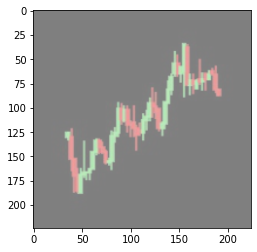

In [7]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(torchvision.utils.make_grid(labels))

In [8]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [9]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [10]:
class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512        
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로 
            #nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [17]:
batch_size = 16
learning_rate = 0.001
num_epoch = 20

In [12]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
from torch.utils.tensorboard import SummaryWriter

loss_arr = []
net_name = '/content/drive/MyDrive/Colab Notebooks/weights/best_weights.pkl'
max_acc = 0

with SummaryWriter('runs') as writer :
  for i in range(num_epoch):
    model = model.train()

    for j, [image, label] in enumerate(trainloader):
      x=Variable(image).to(device)
      y_=Variable(label).to(device)

      optimizer.zero_grad()
      output=model.forward(x)
      loss=loss_func(output,y_)
      loss.backward()
      optimizer.step()

      if j%1000==0:
        print(j, loss)
        loss_arr.append(loss.cpu().detach().numpy())

    model.eval()
    acc = ComputeAccr(testloader, model)
    writer.add_scalar('accuracy', acc, num_epoch)

    if acc > max_acc :
      #print(acc)
      max_acc = acc
      torch.save(model, net_name)

  plt.plot(loss_arr)
  plt.show()
    

0 tensor(1.1285, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.5245, device='cuda:0', grad_fn=<NllLossBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 36.73225784301758
36.73225784301758
0 tensor(0.9833, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.0702, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 36.73225784301758
0 tensor(1.1116, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.0879, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 35.59928512573242
0 tensor(0.9454, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.0304, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 35.59928512573242
0 tensor(1.0179, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.0690, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 36.73225784301758
0 tensor(1.0485, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.2966, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 36.73225784301758
0 tensor(0.9875, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.2596, device='cuda:0', gr

KeyboardInterrupt: ignored